In [1]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_train.csv', 
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_test.csv', 
          'edx_test.csv')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [ ]:
# Importing and cleaning the data

edx = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')
edx['grade'] = pd.to_numeric(edx['grade'],errors='coerce')
edx['grade'] = edx['grade'].replace(np.nan, 0, regex=True)
edx.fillna(-1, inplace = True)
edx.dtypes
edx.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130545492,1,1,1,1,United States,Master's,1984.0,m,1.00,3/10/13,7/29/13,1161.0,50.0,-1.0,12.0,0
1,HarvardX/ER22x/2013_Spring,MHxPC130536944,1,1,1,1,United Kingdom,Master's,1985.0,f,0.85,3/13/13,8/1/13,1360.0,10.0,-1.0,29.0,0
2,HarvardX/CS50x/2012,MHxPC130442298,1,1,1,1,India,-1,-1.0,-1,1.00,8/2/12,7/25/13,77.0,18.0,-1.0,7.0,0
3,HarvardX/ER22x/2013_Spring,MHxPC130273564,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,0.85,1/23/13,8/13/13,1425.0,29.0,-1.0,34.0,0
4,HarvardX/CS50x/2012,MHxPC130247761,1,1,0,0,United States,Secondary,1989.0,m,0.00,3/5/13,3/5/13,6.0,1.0,-1.0,1.0,0


Goal: Predict whether or not a student will complete an online course based on the student's activity
- We need to select features (w/ validation set)
- Train the model
- Try 3 different classifiers (w/ different parameters)
- Test on our testing data

In [ ]:
# Looking at the distribution of the data
completed = edx[edx['certified'] == 1]
uncompleted = edx[edx['certified'] == 0]

print(f'Number students completed: {len(completed)} ({len(completed) * 100.0 / len(edx):.2f}%)')
print(f'Number students uncompleted: {len(uncompleted)} ({len(uncompleted) * 100.0 / len(edx):.2f}%)')

Number students completed: 3889 (44.41%)
Number students uncompleted: 4869 (55.59%)


In [ ]:
## Choosing features and setting the target

features = [
    'course_id',       # name of course (categorical)             
    'final_cc_cname_DI',      # student address (categorical)        
    'LoE_DI',             # highest level of education completed (categorical)
    'YoB',           # year of birth (numerical)
    'gender',       # gender (categorical)
    'grade',        # grade (numerical)                                   
    'nevents',          # number of times interacted with the course (numerical)
    'ndays_act',      # number of unique days student interacted with the course (numerical)
    'nchapters',       # number of chapters the student interacted with (numerical)      
    'nforum_posts',   # number of posts to discussion forum (numerical)
]

target = 'certified'

edx = edx[features + [target]]

# need to hot encode categorical variables
edx = pd.get_dummies(edx, columns=['gender', 'LoE_DI', 'course_id', 'final_cc_cname_DI'])
features = list(edx.columns)
features.remove('certified')
edx.head()

,YoB,grade,nevents,ndays_act,nchapters,nforum_posts,certified,gender_-1,gender_f,gender_m,LoE_DI_-1,LoE_DI_Bachelor's,LoE_DI_Doctorate,LoE_DI_Less than Secondary,LoE_DI_Master's,LoE_DI_Secondary,course_id_HarvardX/CB22x/2013_Spring,course_id_HarvardX/CS50x/2012,course_id_HarvardX/ER22x/2013_Spring,course_id_HarvardX/PH207x/2012_Fall,course_id_HarvardX/PH278x/2013_Spring,final_cc_cname_DI_Australia,final_cc_cname_DI_Bangladesh,final_cc_cname_DI_Brazil,final_cc_cname_DI_Canada,final_cc_cname_DI_China,final_cc_cname_DI_Colombia,final_cc_cname_DI_Egypt,final_cc_cname_DI_France,final_cc_cname_DI_Germany,final_cc_cname_DI_Greece,final_cc_cname_DI_India,final_cc_cname_DI_Indonesia,final_cc_cname_DI_Japan,final_cc_cname_DI_Mexico,final_cc_cname_DI_Morocco,final_cc_cname_DI_Nigeria,final_cc_cname_DI_Other Africa,final_cc_cname_DI_Other East Asia,final_cc_cname_DI_Other Europe,final_cc_cname_DI_Other Middle East/Central Asia,"final_cc_cname_DI_Other North & Central Amer., Caribbean",final_cc_cname_DI_Other Oceania,final_cc_cname_DI_Other South America,final_cc_cname_DI_Other South Asia,final_cc_cname_DI_Pakistan,final_cc_cname_DI_Philippines,final_cc_cname_DI_Poland,final_cc_cname_DI_Portugal,final_cc_cname_DI_Russian Federation,final_cc_cname_DI_Spain,final_cc_cname_DI_Ukraine,final_cc_cname_DI_United Kingdom,final_cc_cname_DI_United States,final_cc_cname_DI_Unknown/Other
0,1984.0,1.00,1161.0,50.0,12.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1985.0,0.85,1360.0,10.0,29.0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-1.0,1.00,77.0,18.0,7.0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1982.0,0.85,1425.0,29.0,34.0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1989.0,0.00,6.0,1.0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


CHOOSING FEATURES

The features we chose were decided based on which variables we thought would make an actual impact on performance of a student. For example, the number of posts they make in a discussion forum indicates level of participation in the class and therefore we would want this included in our model. Unlike "start date" which would probably tell us nothing about the student, other than if they started the class late so we decided to not include this in our model. We transformed the YoB (year of birth) variable from object to numeric type so that it would be easier to work with in our model. We also hot encoded all of our chosen categorical features. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

train_data, validation_data = train_test_split(edx, test_size=0.2, random_state=5)

# Tree Model 1, max depth 1
decision_tree_model = DecisionTreeClassifier(max_depth=1, random_state=6)
decision_tree_model.fit(train_data[features], train_data[target])


train_predictions = decision_tree_model.predict(train_data[features])
validation_predictions = decision_tree_model.predict(validation_data[features])

decision_train_accuracy = accuracy_score(train_data[target], train_predictions)
decision_validation_accuracy = accuracy_score(validation_data[target], validation_predictions)
print(decision_train_accuracy)
print(decision_validation_accuracy)

0.997858978018841
0.9965753424657534


In [ ]:
# Tree Model 2, max depth 3
big_tree_model = DecisionTreeClassifier(max_depth=3, random_state=6)
big_tree_model.fit(train_data[features], train_data[target])

big_train_predictions = big_tree_model.predict(train_data[features])
big_validation_predictions = big_tree_model.predict(validation_data[features])

big_train_accuracy = accuracy_score(train_data[target], big_train_predictions)
big_validation_accuracy = accuracy_score(validation_data[target], big_validation_predictions)
print(big_train_accuracy)
print(big_validation_accuracy)

0.9984299172138167
0.9988584474885844


In [ ]:
## Improving our model but using GridSearchCV to find the best hyperparameters

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
hyperparameters = {'min_samples_leaf': [1, 10, 50, 100, 200, 300], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20]}
clf = DecisionTreeClassifier()
search = GridSearchCV(clf, hyperparameters, cv = 6, return_train_score = True)
search.fit(train_data[features], train_data[target])
params = search.best_params_
best_depth = params['max_depth']
print(best_depth)

7


IMPROVING OUR MODEL PREDICTIONS

To ensure that we were submitting the best version of our Decision Tree model we decided to use GridSearchCV to find the best hyperparameters. Specifically we were trying to find the best depth, and then we inputted that into our "best model" in the cell below.

In [ ]:
# Tree Model 3, max depth - best depth
best_tree_model = DecisionTreeClassifier(max_depth=best_depth, random_state=6)
best_tree_model.fit(train_data[features], train_data[target])

best_train_predictions = best_tree_model.predict(train_data[features])
best_validation_predictions = best_tree_model.predict(validation_data[features])

best_train_accuracy = accuracy_score(train_data[target], best_train_predictions)
best_validation_accuracy = accuracy_score(validation_data[target], best_validation_predictions)
print(best_train_accuracy)
print(best_validation_accuracy)


1.0
1.0


In [ ]:
# Testing our model on another dataset
# Saving our test predictions to a csv

df_test['grade'] = pd.to_numeric(df_test['grade'],errors='coerce')
df_test['grade'] = df_test['grade'].replace(np.nan, 0, regex=True)
df_test.fillna(-1, inplace = True)
features = [
    'course_id',       # name of course (categorical)             
    'final_cc_cname_DI',      # student address (categorical)        
    'LoE_DI',             # highest level of education completed (categorical)
    'YoB',           # year of birth (numerical)
    'gender',       # gender (categorical)
    'grade',        # grade (numerical)                                     
    'nevents',          # number of times interacted with the course (numerical)
    'ndays_act',      # number of unique days student interacted with the course (numerical)
    'nchapters',       # number of chapters the student interacted with (numerical)      
    'nforum_posts',   # number of posts to discussion forum (numerical)
]
df_test2 = df_test[features]
df_test2 = pd.get_dummies(df_test2, columns=['gender', 'LoE_DI', 'course_id', 'final_cc_cname_DI'])
features = list(df_test2.columns)
test_predictions = best_tree_model.predict(df_test2[features])
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = test_predictions
to_save.to_csv('submission.csv', index=False)

Depth 1
Depth 2
Depth 3
Depth 4
Depth 5
Depth 6
Depth 7
Depth 8
Depth 9
Depth 10
Depth 11


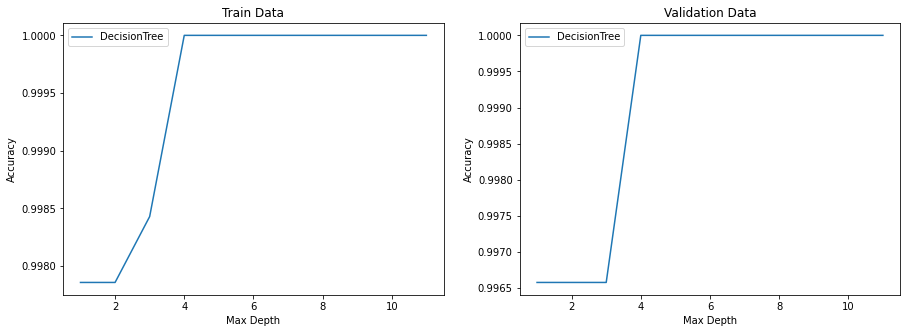

In [ ]:
# Comparing Model Depths using a visualization

import scipy.stats 
import numpy as np

depths = list(range(1, best_depth+5, 1))
dt_accuracies = []

for i in depths:
    print(f'Depth {i}')
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(train_data[features], train_data[target])
    dt_accuracies.append((
        accuracy_score(tree.predict(train_data[features]), train_data[target]),
        accuracy_score(tree.predict(validation_data[features]), validation_data[target])
    ))
     

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(depths, [acc[0] for acc in dt_accuracies], label='DecisionTree')

axs[1].plot(depths, [acc[1] for acc in dt_accuracies], label='DecisionTree')


axs[0].set_title('Train Data')
axs[1].set_title('Validation Data')
for ax in axs:
    ax.legend()
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Accuracy')


VISUALIZATION

The code block above creates two graphs to compare our models as the max-depth changes. Graph one shows our training accuracy score and graph two shows our validation accuracy score. As you can see, the training score grows as it increases until it hits a plateau at a depth of 4 for 100%. This would be concerning for overfitting, however our validation accuracy follows the same trend. From this, we can infer that our data likley has a strong predictor of certification and that around a depth of 4 variable decscion nodes it can make a very accruate prediction. We can also infer that if we use a depth much larger than 4 we will likely have an overfitted model; even though the accruacy score in the graph shows 100% at all depths higher than 4 it does not neccessarily translate the same to future data.

ETHICAL IMPLICATIONS

When considering the ethical implications of classifying students into online learning programs, both bias and fairness need to be taken into account. The company should recignize the tradeoff that often occurs between model accuracy and fairness. The overall goal of the model is to maximize profits by tailoring course material to get more people to sign up. However, it is important to consider the prejudice and bias that comes along with the goal of only maximizing profits. The company should consider how highly they value their customers representing the demographics of the overall population. Gender and ethnicity can often correlate with the odds of one's educational success, so it is important to know how heavily these factors are weighted when training the data. 

The failure to take into account the education performance of underrepresented populations is a result of historical bias, which means that even accurate data could stil be harmful. In addition to historical bias, representation bias may occur based on only collecting data from students that have the resources to access online education services. To address these biases the company needs to be clear and transparent about how the data is collected, and what variables are being used for their model's deciaion making.